In [51]:
import numpy as np
np.random.seed(42)
from scipy.stats import loguniform
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import os
import io
import warnings
#sklearn imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression,RidgeClassifier
from sklearn.metrics import hinge_loss
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,precision_recall_curve
from sklearn.metrics import precision_score,recall_score,classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import log_loss
from sklearn.model_selection import cross_val_predict,cross_validate,GridSearchCV
from pprint import pprint
import pandas as pd

## Handwritten digit classification 

First we will build a binary classification model and then extend it to multiclass classification

In [4]:
X,y = fetch_openml('mnist_784',version=1,return_X_y=True)


Now as we have imported our data, before working on them first let's convert them to numpy array

In [35]:
X_array = X.to_numpy()
y_array = y.to_numpy()

Let's have a look at the images

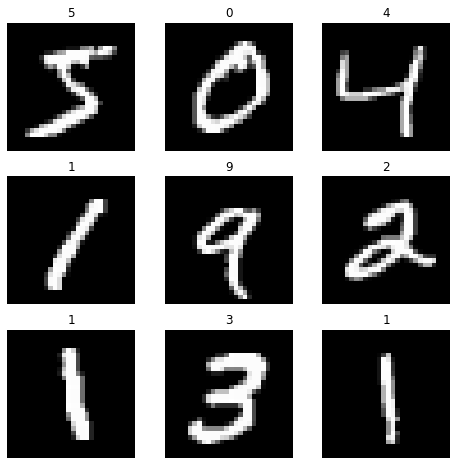

In [36]:
num_images = 9
factor = np.int64(np.sqrt(num_images))
fig,axes = plt.subplots(factor,factor,figsize=(8,8))
idx_offset = 0
for i in range(factor):
    index = idx_offset+i*factor
    for j in range(factor):
        axes[i,j].imshow(X_array[index+j].reshape(28,28),cmap='gray')
        axes[i,j].set_title(y[index+j])
        axes[i,j].set_axis_off()

In [37]:
#for sanity check 
print(X_array.shape,y_array.shape)
print(type(X_array),type(y_array))

(70000, 784) (70000,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


#### Preprocessing

- Sigmoid function requires scaling , so we will scale the features from 0 to 1
- Since there is only one preprocessing step we will not consider making a pipeline

In [8]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_array)

In [38]:
print('target names:',np.unique(y_array))

target names: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


As we are done with preprocessing and now let's split the data into training and test set

In [39]:
X_train,X_test,y_train,y_test = X_scaled[:60000],X_scaled[60000:],y_array[:60000],y_array[60000:]

In [40]:
#again for sanity check let's see the dimensions of the data
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)


(60000, 784) (60000,)
(10000, 784) (10000,)


Now to convert this problem to a binary classification problem we will convert all the labels to 0 and 1
- 1 if value is 0
- 0 if value is 1

In [41]:
y_train_0 = 1*np.zeros(y_train.shape)
y_test_0 = 1*np.zeros(y_test.shape)
#now all labels are 1
indx_0 = np.where(y_train=='0')
y_train_0[indx_0] = 1
indx_0 = np.where(y_test=='0')
y_test_0[indx_0] = 1

In [13]:
print(y_train[:10])

print(y_train_0[:10])

# look at the output and see convesion is fdone correctly or not

['5' '0' '4' '1' '9' '2' '1' '3' '1' '4']
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


First we will try to train the model without regularization, hence we will set alpha to 0, and loss to log to perform logistic regression


In [14]:
bin_clf_sgd = SGDClassifier(loss = 'log' ,penalty ='l2',max_iter =1, warm_start = True,eta0 = 0.01,alpha = 0,learning_rate = 'constant',random_state = 42)

In [ ]:
loss = []
iterations = 100
for i in range(iterations):
    bin_clf_sgd.fit(X_train,y_train_0)
    y_pred = bin_clf_sgd.predict_proba(X_train)
    loss.append(log_loss(y_train_0,y_pred))


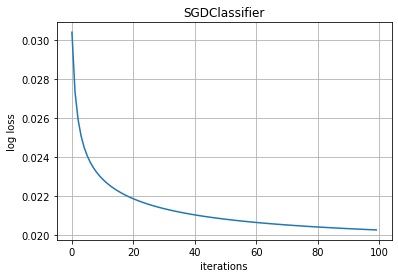

In [16]:
plt.figure()
plt.plot(np.arange(iterations),loss)
plt.grid(True)
plt.xlabel('iterations')
plt.ylabel('log loss')
plt.title('SGDClassifier')
plt.show()

As training is done let's check the performance of the model on the test set

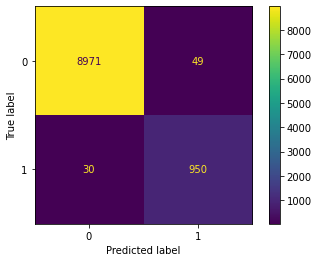

In [17]:
y_predicted = bin_clf_sgd.predict(X_test)
cm_display = ConfusionMatrixDisplay.from_predictions(y_test_0,y_predicted,labels=[0,1],values_format='.5g')

plt.show()

In [18]:
print(classification_report(y_test_0,y_predicted))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9020
         1.0       0.95      0.97      0.96       980

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



### Logistic Regression

In previous setup we have used SGDClassifier to train the model in a iterative maner by finding the optimal weights for the model, In next setup we will be doing the similar thing using Logistic Regression, where we will be solve the problem by setting derivative of the cost function to 0

- Sklearn uses solver liblinear , newton-cg , sag , saga and lbfgs to find optimal weights
- First we will try un regularized logistic regression by setting the parameter C to infinity
- Important thing to note is here also we will need to Scale the features to 0 to 1

In [45]:
pipe_logit = Pipeline([('logit',LogisticRegression(random_state =42 , solver = 'lbfgs',C = 100,max_iter=10000))])

pipe_logit.fit(X_train,y_train_0)

Pipeline(steps=[('logit',
                 LogisticRegression(C=100, max_iter=10000, random_state=42))])

In [46]:
y_predict_logit = pipe_logit.predict(X_test)

In [50]:
print(classification_report(y_test_0,y_predict_logit))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      9020
         1.0       0.95      0.96      0.96       980

    accuracy                           0.99     10000
   macro avg       0.97      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



##### Now let's extend this model to multiclass classification

In [52]:
estimator = SGDClassifier(loss = 'log' ,penalty ='l2',max_iter =1, warm_start = True,eta0 = 0.01,alpha = 0,learning_rate = 'constant',random_state = 42)
pipe_sgd_multi = make_pipeline(MinMaxScaler(),estimator)

In [ ]:
Loss_sgd_multi = []
iterations = 100
for i in range(iterations):
    pipe_sgd_multi.fit(X_train,y_train)
    y_pred = pipe_sgd_multi.predict_proba(X_train)
    Loss_sgd_multi.append(log_loss(y_train,y_pred))

Let's have a look at the loss curve

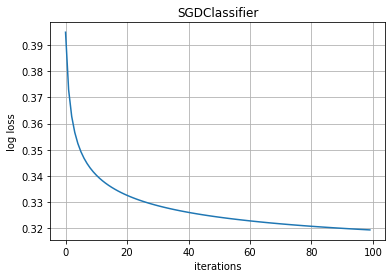

In [55]:
plt.figure()
plt.plot(np.arange(iterations),Loss_sgd_multi)
plt.grid(True)
plt.xlabel('iterations')
plt.ylabel('log loss')
plt.title('SGDClassifier')
plt.show()


Now it's look at some evaluation metrics

In [57]:
y_pred_multi = pipe_sgd_multi.predict(X_test)
print(classification_report(y_test,y_pred_multi))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       980
           1       0.97      0.98      0.97      1135
           2       0.90      0.92      0.91      1032
           3       0.90      0.90      0.90      1010
           4       0.90      0.93      0.92       982
           5       0.89      0.86      0.87       892
           6       0.94      0.94      0.94       958
           7       0.92      0.92      0.92      1028
           8       0.88      0.87      0.88       974
           9       0.92      0.86      0.89      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



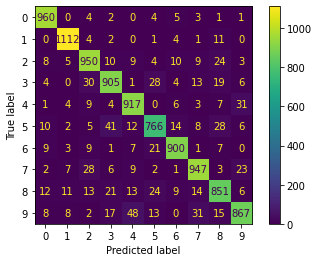

In [59]:
cm_display = ConfusionMatrixDisplay.from_predictions(y_test,y_pred_multi)  
plt.show()

As per evaluation model is performing pretty well on the test set also